In [92]:
#Q1
import numpy as np
import copy

DEFAULT_CONT = 1

def get_open_spaces(board):
    open_spaces = []
    for i in range(len(board)):
        for j in range(len(board[i])):
            if (board[i][j] == 0):
                open_spaces.append((i,j))
    return open_spaces

def is_winner(board, circle=True):
    goal = len(board)
    if (not circle):
        goal *= -1

    # Check rows
    for i in range(len(board)):
        if (sum(board[i]) == goal):
            return True

    # Check cols
    for i in range(len(board[i])):
        if (sum(board[:,i]) == goal):
            return True

    # Check diagonal
    d1 = [board[x][x] for x in range(len(board))]
    d2 = [board[x][len(board)-x-1] for x in range(len(board))]
    if (sum(d1) == goal or sum(d2) == goal):
        return True

    return False

def get_reward(board, num_open_spaces, cont):
    if (is_winner(board, True)): # Player wins
        return 10
    if (is_winner(board, False)): # Opponent wins
        return -10
    if (num_open_spaces == 0):
        return 0
    return cont

def random_move(board, open_spaces, isplayer):
    if isplayer:
        marker = 1
    else:
        marker = -1
    index = np.random.randint(0, len(open_spaces))
    board[open_spaces[index]] = marker

def calculate_rewardtogo(reward, discount):
    rewardtogo = [0. for i in range(len(reward))] 
    for i in range(len(reward)):
        for j in range(i, len(reward)):
            rewardtogo[i] += reward[j] * discount ** (j-i)
    return rewardtogo

def MDP(board):
    states = []
    reward = [] # reward at each state
    player_turn = False
    while (True):
        open_spaces = get_open_spaces(board)
        r = get_reward(board, len(open_spaces), DEFAULT_CONT)
        if player_turn:
            states.append(copy.deepcopy(board))
            reward.append(r)
        if (r != 1): # Game over
            if r == 10:
                states.append(copy.deepcopy(board))
                #reward.append(r) state and reward before terminal cases
                
            break
        random_move(board, open_spaces, player_turn)
        if player_turn:
            player_turn = False
        else:
            player_turn = True
    return reward, states

init_board = np.zeros((3,3))
discount = 0.9
seeds = [6,1,2,3,4]
for i in range(len(seeds)):
    np.random.seed(seeds[i])
    board = copy.deepcopy(init_board)
    reward,states = MDP(board)
    rewardtogo = calculate_rewardtogo(reward, discount)
    print('TRAJECTORY\n', states)
    for i in range(len(rewardtogo)):
        print('State:')
        print(states[i])
        print('Reward to go: ', rewardtogo[i])
        print('')

                        

TRAJECTORY
 [array([[ 0.,  0.,  0.],
       [-1.,  0.,  0.],
       [ 0.,  0.,  0.]]), array([[ 0.,  0., -1.],
       [-1.,  0.,  1.],
       [ 0.,  0.,  0.]]), array([[ 0.,  0., -1.],
       [-1., -1.,  1.],
       [ 0.,  0.,  1.]]), array([[ 1.,  0., -1.],
       [-1., -1.,  1.],
       [ 0., -1.,  1.]]), array([[ 1., -1., -1.],
       [-1., -1.,  1.],
       [ 1., -1.,  1.]])]
State:
[[ 0.  0.  0.]
 [-1.  0.  0.]
 [ 0.  0.  0.]]
Reward to go:  -3.122

State:
[[ 0.  0. -1.]
 [-1.  0.  1.]
 [ 0.  0.  0.]]
Reward to go:  -4.580000000000001

State:
[[ 0.  0. -1.]
 [-1. -1.  1.]
 [ 0.  0.  1.]]
Reward to go:  -6.200000000000001

State:
[[ 1.  0. -1.]
 [-1. -1.  1.]
 [ 0. -1.  1.]]
Reward to go:  -8.0

State:
[[ 1. -1. -1.]
 [-1. -1.  1.]
 [ 1. -1.  1.]]
Reward to go:  -10.0

TRAJECTORY
 [array([[ 0.,  0.,  0.],
       [ 0.,  0., -1.],
       [ 0.,  0.,  0.]]), array([[ 0.,  0.,  0.],
       [ 1.,  0., -1.],
       [-1.,  0.,  0.]]), array([[ 1.,  0., -1.],
       [ 1.,  0., -1.],
       

In [91]:
def get_all_states(board, all_states, turn, cont):
    skip = False
    if turn:
        board_str = np.array2string(board)
        if board_str in all_states:
            skip = True
        else:
            all_states[board_str] = copy.deepcopy(board)
    open_spaces = get_open_spaces(board)
    r = get_reward(board, len(open_spaces), cont)
    if r == cont or not skip: # Game is not over
        for i in open_spaces:
            if turn:
                board[i] = 1
            else:
                board[i] = -1
            get_all_states(copy.deepcopy(board), all_states, not turn, cont)
            board[i] = 0


In [132]:
import collections
def value_iteration(init_board, discount, cont):
    all_states = {}
    board = copy.deepcopy(init_board)
    get_all_states(board, all_states, False, cont)

    new_values = {k:0 for k in all_states}
    it = 0
    # start from 0
    res = collections.defaultdict(lambda:[0])
    while (True):
        values = copy.deepcopy(new_values)
        delta = 0
        for s in all_states.keys():
            curr_state = copy.deepcopy(all_states[s])
            open_spaces = get_open_spaces(curr_state)
            r = get_reward(curr_state, len(open_spaces), cont)
            # Get max player action
            best_action = 0.
            if r == cont:
                for i in range(len(open_spaces)):
                    curr_action = 0.
                    num_pos = 0.
                    for j in range(len(open_spaces)):
                        if (i != j):
                            num_pos += 1
                            player_move = open_spaces[i]
                            opponent_move = open_spaces[j]
                            tmp_state = copy.deepcopy(curr_state)
                            tmp_state[player_move] = 1
                            tmp_state[opponent_move] = -1
                            board_str = np.array2string(tmp_state)
                            if (board_str in values):
                                curr_action += values[board_str]
                    curr_action = curr_action / num_pos
                    if (curr_action > best_action):
                        best_action = curr_action 
            # Set updated value
            new_values[s] = r + discount * best_action
      
            if res[s][-1] is None:
                continue
            res[s].append(new_values[s])

            value_change = abs(new_values[s] - values[s])
            if value_change < 0.1: # terminal cases reaches first for some states
                res[s].append(None)
            if value_change > delta:
                delta = abs(new_values[s] - values[s])

        if (delta < 0.1):
            break
        it += 1
    return res

In [133]:

board = copy.deepcopy(init_board)
target = np.array([[-1.,0.,-1.], [1.,1.,0.], [ -1.,  0., 0.]])
target_string = np.array2string(target)
values = value_iteration(board, discount, DEFAULT_CONT)


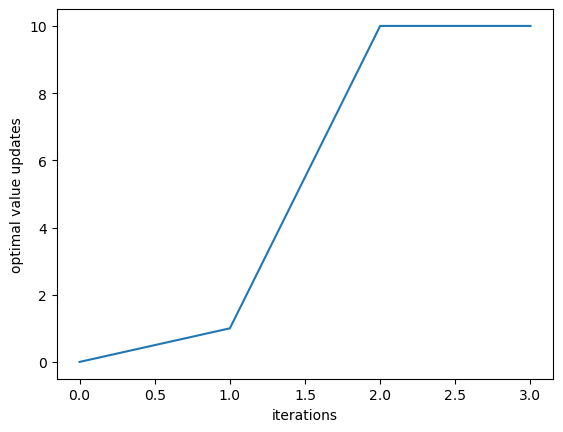

In [137]:
#Q2
target = np.array([[-1.,0.,-1.], [1.,1.,0.], [ -1.,  0., 0.]])
# the board in figure 1
target_string = np.array2string(target)

value_updates = values[target_string][:-1]

import matplotlib.pyplot as plt
plt.plot(value_updates)
plt.ylabel('optimal value updates')
plt.xlabel('iterations')
plt.show()
